# Import Packages

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

from anaysis.src.bivariate_analysis import BivariateAnalyzer, CategoricalVsNumericalAnalysis, StoreItemSalesBivariateAnalysis
from anaysis.src.feature_engineering import FeatureEngineer, DateFeatureEngineeringStrategy

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

# Loading data

In [2]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
data = pd.concat([train_data, test_data], sort=False)

# Exploratory Data Analysis
## Date Ranges

In [3]:
print(f"Min Date: {data['date'].min()}")
print(f"Max Date: {data['date'].max()}")

Min Date: 2013-01-01
Max Date: 2018-03-31


#### Key Observations
- The data spans from January 1, 2013 to March 31, 2018.
- The range covers approximately 5+ years, suggesting a relatively long observation period.

## Shape of DataFrame

In [4]:
print(data.shape)

(958000, 5)


#### Key Observations
- The dataset comprises 958,000 records and 5 features, providing a substantial volume of data for analysis. Each record represents an observation, and the 5 features offer key attributes to explore relationships, trends, and patterns within the data

## Data Types

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    958000 non-null  object 
 1   store   958000 non-null  int64  
 2   item    958000 non-null  int64  
 3   sales   913000 non-null  float64
 4   id      45000 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 43.9+ MB
None


#### Key Insights
- The `date` column is currently of object type and should be converted to datetime for proper analysis.

## Data Type Conversion

In [6]:
data['date'] = pd.to_datetime(data['date'])

## Unique values for each feature

In [7]:
data.nunique()

date      1916
store       10
item        50
sales      213
id       45000
dtype: int64

#### Key Observations
- The dataset comprises 1,916 unique dates, 10 distinct stores, 50 unique items, and 213 unique sales values. This rich structure enables a detailed analysis of sales patterns over time, item performance across different stores, and trends in sales values.

## Observing first and last 5 entries

In [8]:
print(data.head())
print(data.tail())

        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0


#### Key Insights
- Sales Column: `NaN` values at the end represent missing target values in the test dataset, which need to be predicted.
- ID Column: Missing `id` values in the train set are expected since they are not required for model training.
## Descriptive Statistics

In [9]:
print(data.describe().T)

          count                           mean                  min                  25%                  50%                  75%                  max           std
date     958000  2015-08-16 11:59:59.999999744  2013-01-01 00:00:00  2014-04-24 18:00:00  2015-08-16 12:00:00  2016-12-07 06:00:00  2018-03-31 00:00:00           NaN
store  958000.0                            5.5                  1.0                  3.0                  5.5                  8.0                 10.0      2.872283
item   958000.0                           25.5                  1.0                 13.0                 25.5                 38.0                 50.0     14.430877
sales  913000.0                      52.250287                  0.0                 30.0                 47.0                 70.0                231.0     28.801144
id      45000.0                        22499.5                  0.0             11249.75              22499.5             33749.25              44999.0  12990.525394


#### Key Insights
- **Missing Sales Data:** The discrepancy in sales count (913,000 vs. 958,000) confirms missing sales values in the test dataset.
- **Sales Distribution:** Sales are right-skewed, as the mean (52.25) is greater than the median (47.0). This suggests that while most sales hover around 30–70, there are some higher sales values (up to 231) contributing to the skew.
- **Even Distribution of Stores and Items:** Both store and item values are evenly spread across their respective ranges, which is useful for balanced analysis.

## Sales by Store

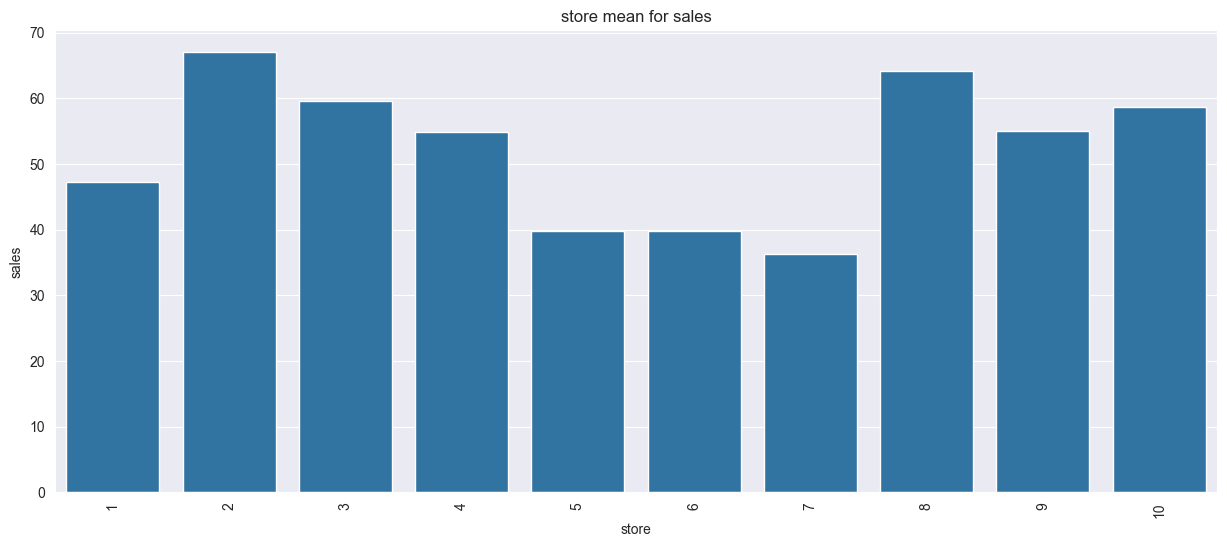

In [10]:
bivariate_Analyzer = BivariateAnalyzer(CategoricalVsNumericalAnalysis())
bivariate_Analyzer.analyze(data, 'store', 'sales')

## Sales by Item

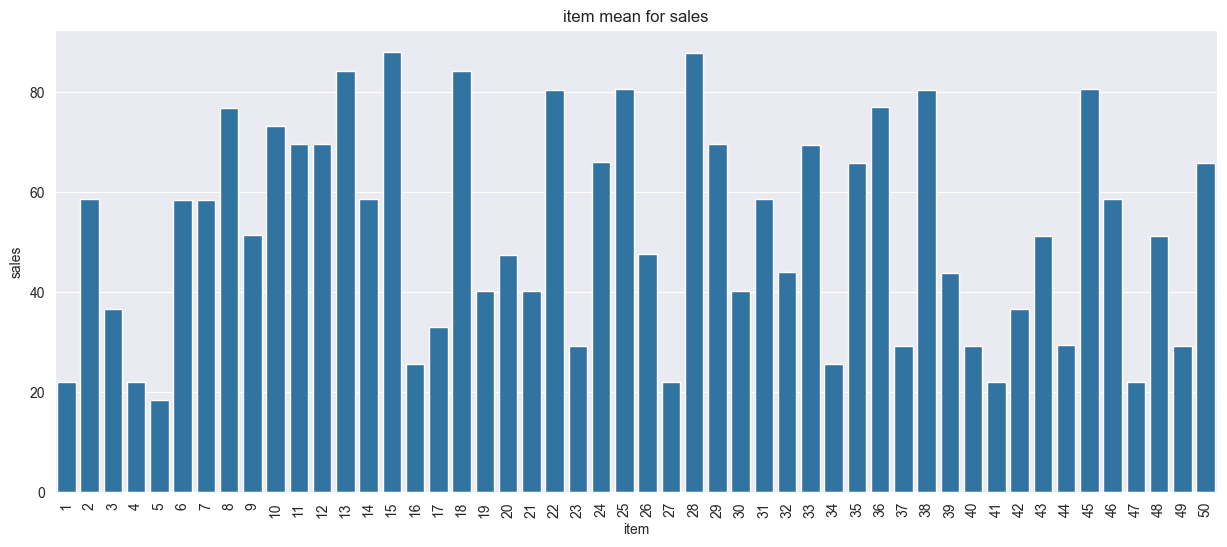

In [11]:
bivariate_Analyzer = BivariateAnalyzer(CategoricalVsNumericalAnalysis())
bivariate_Analyzer.analyze(data, 'item', 'sales')

# Sales by Store and Item

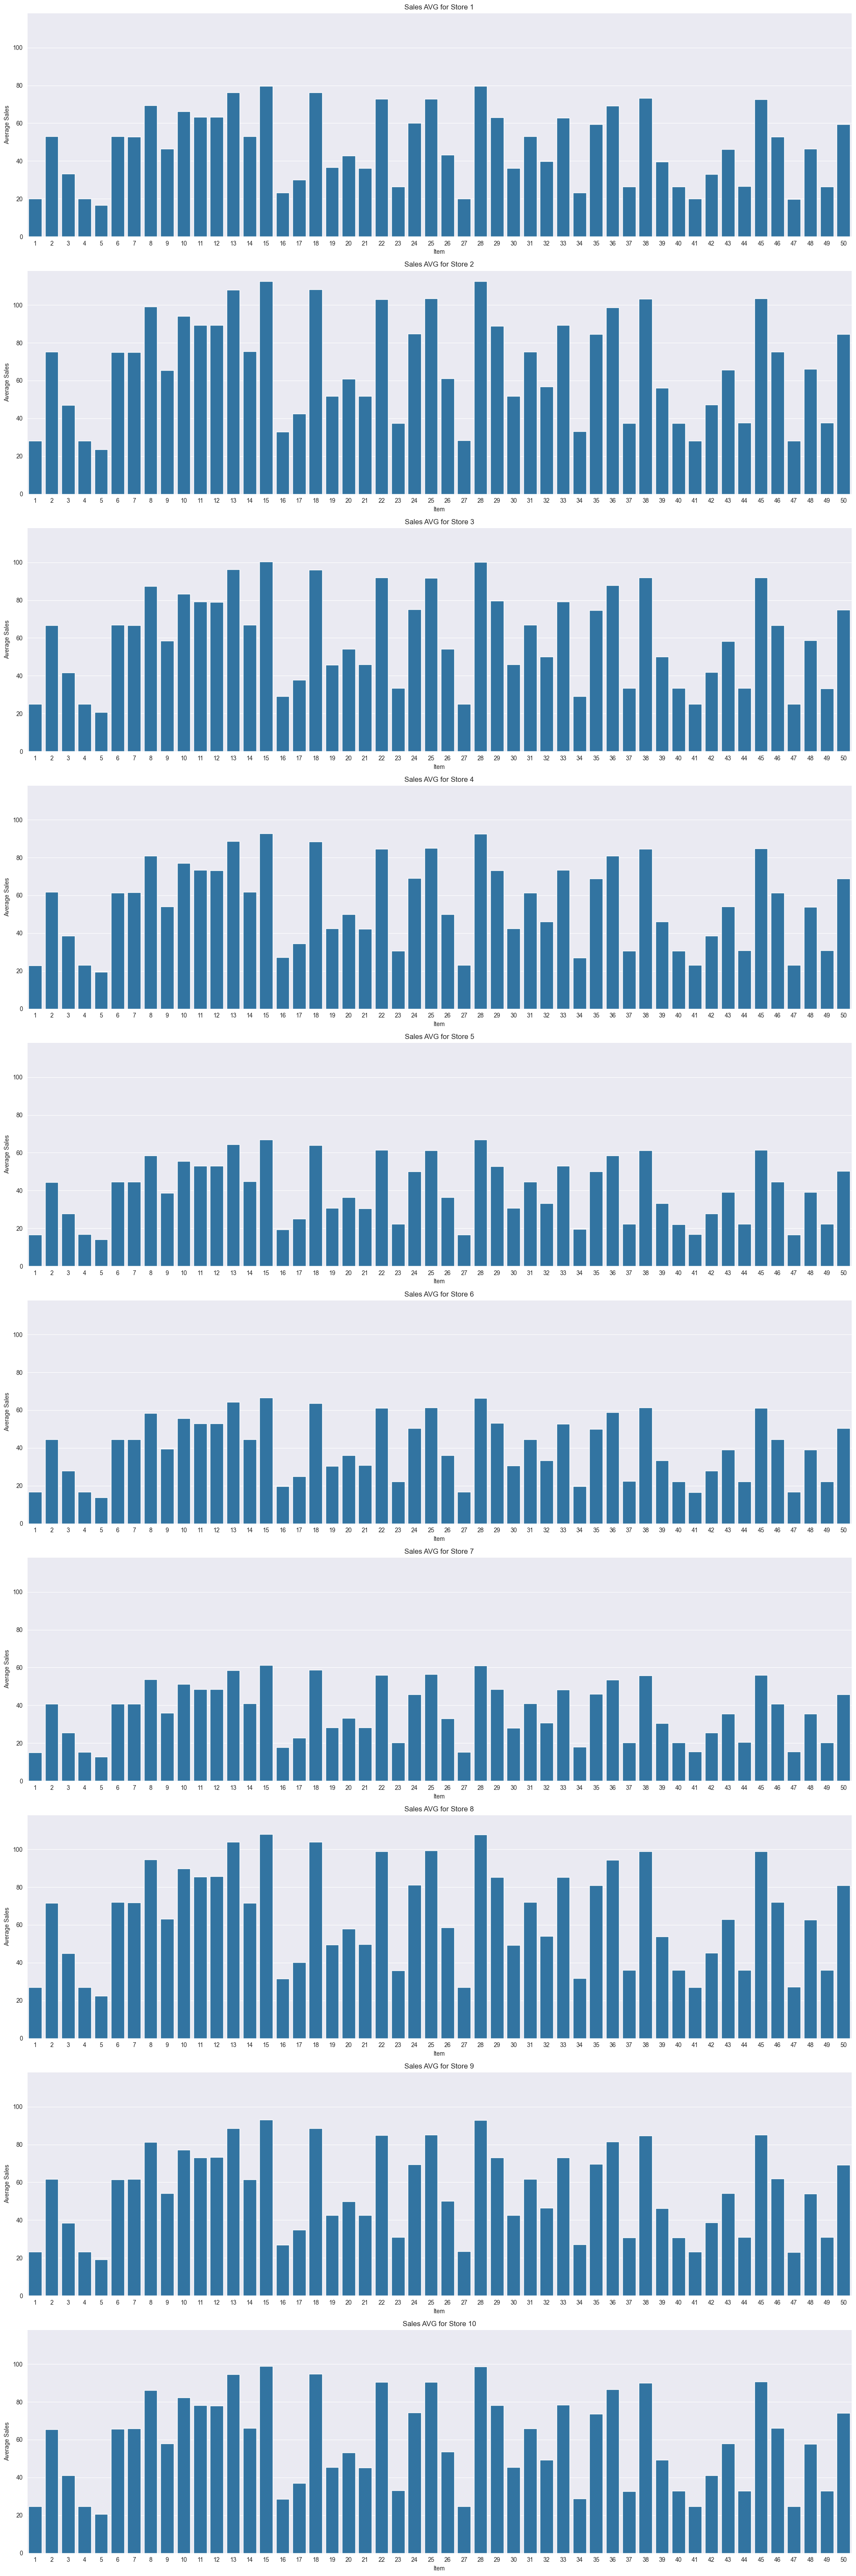

In [12]:
bivariate_Analyzer = BivariateAnalyzer(StoreItemSalesBivariateAnalysis())
bivariate_Analyzer.analyze(data, 'store', 'item')

# Feature Engineering